Importing the required libraries


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import scipy.stats as stats

Next we read the dataset..

In [15]:
data=pd.read_csv("D:\\Interviews\\AB_NYC_2019.csv")
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


We move on to see the features..

In [16]:
data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

Now let us move on to preprocessing

In [17]:


total=data.isnull().sum().sort_values(ascending=False)
percent=(data.isnull().sum())/data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)



,Total,Percent
reviews_per_month,10052,0.205583
last_review,10052,0.205583
host_name,21,0.000429
name,16,0.000327
availability_365,0,0.000000
calculated_host_listings_count,0,0.000000
number_of_reviews,0,0.000000
minimum_nights,0,0.000000
price,0,0.000000
room_type,0,0.000000


Now we move on to deal with the missing values..

In [18]:
data.drop(['host_name','name'], axis=1, inplace=True)

We fill the missing values for the reviews_per_month with 0 

In [20]:

data['reviews_per_month']=data['reviews_per_month'].fillna(0)

In [21]:
data['last_review'] = pd.to_datetime(data['last_review'],infer_datetime_format=True) 
earliest = min(data['last_review'])
data['last_review'] = data['last_review'].fillna(earliest)
data['last_review'] = data['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

The machine learning model here at AirBNB is Smart Pricing.
After a client has entered the details of their rental,AirBNB suggests an appropriate price. 
The aim of this notebook is to build and train a Smart Pricing model for this dataset.


Lets move on to check the price distribution

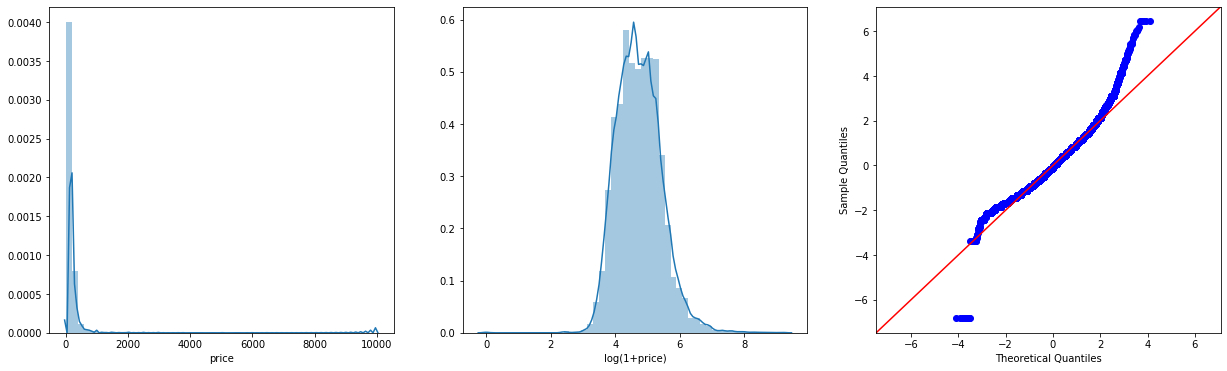

In [26]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

we can notice that the target has a highly skewed distribution. This can cause problems for machine learning algorithms such as linear regression. 
A log transformation and removal of outliers makes the distribution look much closer to normal.

In [29]:
data = data[np.log1p(data['price']) < 8]
data = data[np.log1p(data['price']) > 3]

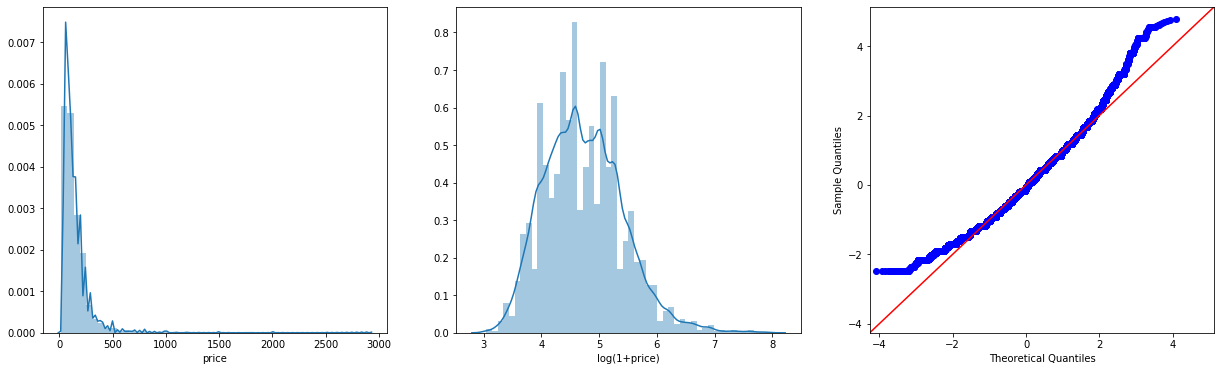

In [30]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [33]:
data['price'] = np.log1p(data['price'])

Next we drop the host_id column,since this wont be helpful in the prediction process

In [34]:
data = data.drop(['host_id', 'id'], axis=1)

Let's just check out the minimum nights column

Text(0, 0.5, 'count')

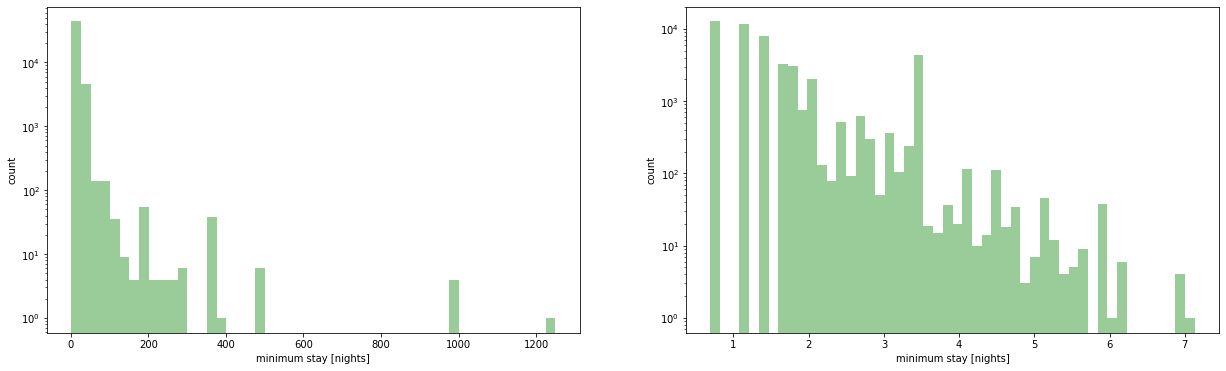

In [36]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))

sns.distplot(data['minimum_nights'], rug=False, kde=False, color="green", ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum stay [nights]')
axes[0].set_ylabel('count')

sns.distplot(np.log1p(data['minimum_nights']), rug=False, kde=False, color="green", ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum stay [nights]')
axes[1].set_ylabel('count')

In [37]:


data['minimum_nights'] = np.log1p(data['minimum_nights'])



In [38]:
data['reviews_per_month'] = data[data['reviews_per_month'] < 17.5]['reviews_per_month']

Feature Engineering

In [39]:
data['all_year_avail'] = data['availability_365']>353
data['low_avail'] = data['availability_365']< 12
data['no_reviews'] = data['reviews_per_month']==0

 Pearson correlation matrix

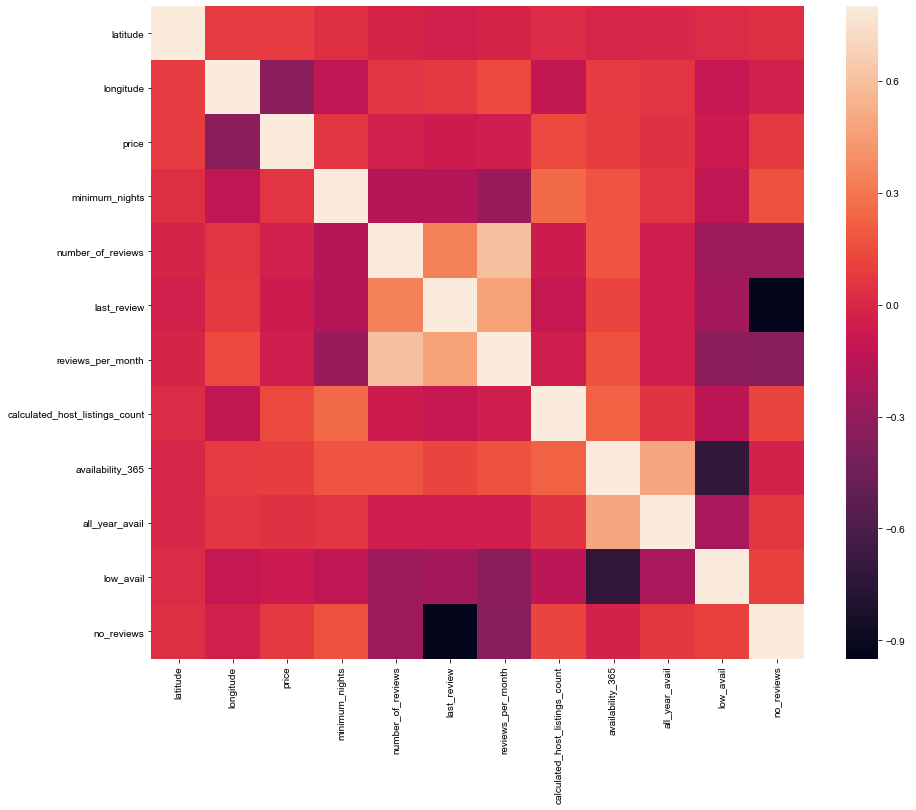

In [40]:
corrmatrix = data.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)



There don't appear to exist obvious, strong correlations between these variables.

However, the number of reviews per month is fairly (40%) correlated with the total number of reviews and the the total number of reviews is correlated (at 30%) with the availability of the property. Both of these correlations make sense.

Encoding categorical features

In [41]:
categorical_features =data.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))

Categorical features: (48784, 3)


In [42]:
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [43]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

Save transformed dataframe for future use

In [44]:
numerical_features =  data.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
print('Numerical features: {}'.format(numerical_features.shape))

Numerical features: (48784, 11)


In [45]:
X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

In [46]:
Processed_data = pd.concat([X_df, y], axis = 1)
Processed_data.to_csv('NYC_Airbnb_Processed.dat')

Train-test split

In [48]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I now scale the design matrix with sklearn's RobustScaler() so that each predictor has zero mean and unit variance.

In [50]:
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

K fold cross validation carried out for k=5

In [52]:
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

Scoring basic models (no parameter tuning)

In [56]:
for Model in [RandomForestRegressor]:
    cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

RandomForestRegressor: 0.00542 +/- 0.000163


Now Prediction has been carried out using random forest


In [64]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
rfr_CV_baseline = -rmse_cv(RandomForestRegressor(random_state=42))
rfr_baseline = RandomForestRegressor(random_state=42)
rfr_baseline.fit(X_train, y_train) 
y_train_rfr = rfr_baseline.predict(X_train)
y_test_rfr = rfr_baseline.predict(X_test)
rfr_baseline_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
                             'CV error': rfr_CV_baseline.mean(), 
            'CV std': rfr_CV_baseline.std(),          
            
            'training error': [mean_squared_error(y_train_rfr, y_train)],
            'test error': [mean_squared_error(y_test_rfr, y_test)]})

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

In [65]:


rfr_baseline_results



,algorithm,CV error,CV std,training error,test error
0,Random Forest Regressor [baseline],0.005371,0.000111,0.00095,0.00557




We see that the training error is nearly an order of magnitude smaller than the test error, and the training error for any of the other algorithms. The baseline model is overfitting massively! Let's look at the baseline model's parameter values.


In [66]:
print(rfr_baseline.estimators_)

[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1608637542, splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1273642419, splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_

In [69]:
import eli5
eli5.show_weights(rfr_baseline, feature_names=list(X_df.columns))

Using TensorFlow backend.


Weight,Feature
0.4089 ± 0.0059,room_type_Entire home/apt
0.1324 ± 0.0241,longitude
0.1186 ± 0.0156,latitude
0.0600 ± 0.0041,availability_365
0.0434 ± 0.0043,minimum_nights
0.0403 ± 0.0035,last_review
0.0363 ± 0.0047,reviews_per_month
0.0359 ± 0.0238,neighbourhood_group_Manhattan
0.0331 ± 0.0019,number_of_reviews
0.0284 ± 0.0037,calculated_host_listings_count



Hyperparameter tuning

In [70]:
rf = RandomForestRegressor(random_state=42)
from pprint import pprint
print('Parameters currently in use: \n')
pprint(rf.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [71]:
#Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop=2000,num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions = random_grid, n_iter=10, cv = 3, verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:


#best_random = rf_random.best_estimator_
best_random = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=1400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
rfr_CV_best = -rmse_cv(best_random)
best_random.fit(X_train, y_train) 
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)
rfr_best_results = pd.DataFrame({'algorithm':['Random Forest Regressor'],
            'CV error': rfr_CV_best.mean(), 
            'CV std': rfr_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_rfr)],
            'test error': [mean_squared_error(y_test, y_test_rfr)],
            'training_r2_score': [r2_score(y_train, y_train_rfr)],
            'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results



In [ ]:
eli5.show_weights(best_random, feature_names=list(X_df.columns))